In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import sklearn
from random import random 
from random import sample 
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.utils import class_weight
from sklearn import svm, datasets
import matplotlib 

matplotlib.rc('font', **{'size'   : 16})

In [3]:
DATA = "../preprocessing/standardized_data.csv"
data = pd.read_csv(DATA,header=0)

In [4]:
data[["Race", "Age", "Gender", "Emotion"]]

,Race,Age,Gender,Emotion
0,4,25,2,1
1,4,25,2,5
2,4,25,2,5
3,4,25,2,2
4,4,25,2,4
...,...,...,...,...
2672,4,25,1,-1
2673,4,25,1,-1
2674,4,35,1,-1
2675,4,25,1,-1


## Again, reusing the misclassification definitions

In [5]:
def gender_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been gender misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    for i in range(n): 
        # If the ground truth or the result from the API is "unsure", no misclassification
        if gt[i] == 0 or prediction[i] == 0: 
            result[i] = 0
        # If the ground truth does not match the prediction, set the misclassification bit to one. 
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [6]:
def race_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been race misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    for i in range(n): 
        # If the subjects is within a cornercase group or the prediction has outputed "not sure", then 
        # no misclassification
        if gt[i] in [0,5] or prediction[i] == 0 : 
            result[i] = 0
        # If the ground truth does not match the prediction, set the misclassification bit to one. 
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [7]:
def age_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been age misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    
    for i in range(n): 
        tolerance = 0 
        # If the subject is a child, tolerance interval equals 5
        if gt[i] <= 10: 
            tolerance = 5
        # For teenagers and pre-young-adults, tolerance is 10
        elif gt[i] <= 25: 
            tolerance = 10
        # For the rest of the population, tolerance is 15
        else: 
            tolerance = 15
            
        if gt[i] - tolerance <= prediction[i] <= gt[i] + tolerance: 
            result[i] = 0
        else: 
            result[i] = 1
    return result

In [13]:
def emotion_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been emotion misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    
    for i in range(n): 
        # If dealing with one of the undefined emotions, set the misclassification bit to 0
        if gt[i] <= 0 or prediction[i] <= 0: 
            result[i] = 0 
        # If emotions don't match, set the misclassification bit to 1
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [8]:
def recall(estimator, X, y): 
    """ Calculate the recall of the estimator predicting on inputs X with output labels y"""

    prediction = estimator.predict(X)
    
    y = np.array(y)
    prediction = np.array(prediction)
        
    tp = 0
    fn = 0
    
    for i in range(y.size): 
        if y[i] == 1 and prediction[i] == 1:
            tp += 1
            continue 
        if y[i] == 1 and prediction[i] == 0: 
            fn += 1
            
    return (tp / (tp + fn))

In [9]:
def precision(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = estimator.predict(X)
    
    y = np.array(y)
    prediction = np.array(prediction)
    tp = 0
    fp = 0
    for i in range(y.size):
        if y[i] == 1 and prediction[i] == 1:
            tp += 1
            continue
        if y[i] == 0 and prediction[i] == 1:
            fp += 1
    return (tp / (tp + fp))

In [10]:
def plot_scores(model, data=None, outputs=None): 
    """Given a classifier, display the cross-validation score on data (by default X_scaled) using 
    expected_cost, recall, precision and accuracy and scoring functions.""" 
    if data is None: 
        data = X_scaled
    if outputs is None: 
        outputs = y 
    recall_scores = cross_val_score(model, data, outputs, cv=5, scoring=recall)
    precision_scores = cross_val_score(model, data, outputs, cv=5, scoring=precision)
    accuracy_scores = cross_val_score(model, data, outputs, cv=5, scoring="accuracy")

    rec = sum(recall_scores)/10 
    prec = sum(precision_scores)/10
    acc = sum(accuracy_scores)/10
    
    df = pd.DataFrame((rec, prec, acc), index=["Recall", "Precision", "Accuracy"], columns=["Performance"])
    return df

# Gender Misclassification

In [11]:
data_no_ai = data[data["Origin"] != "AI"]
gender_misclassification(data_no_ai["Gender"], data_no_ai["clarifai_gender"])

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
sum(gender_misclassification(data_no_ai["Gender"], data_no_ai["clarifai_gender"]))

285.0

In [13]:
cl = gender_misclassification(data_no_ai["Gender"], data_no_ai["clarifai_gender"]) == 1
ms = gender_misclassification(data_no_ai["Gender"], data_no_ai["microsoft_gender"]) == 1
am = gender_misclassification(data_no_ai["Gender"], data_no_ai["amazon_gender"]) == 1
fa = gender_misclassification(data_no_ai["Gender"], data_no_ai["face++_gender"]) == 1

In [14]:
gender_misclass = (cl | ms | am |fa)
sum(gender_misclass)

372

In [15]:
len(data_no_ai)

2429

In [16]:
X = data_no_ai[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in gender_misclass]

In [17]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [18]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
lr = LogisticRegression(solver='lbfgs') 

In [21]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.8604668656997108

In [22]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [23]:
sum(prediction)

12

In [24]:
is_actually_misclass = np.array(y_test) == 1
is_not_misclass = np.array(y_test) == 0

In [25]:
sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)

0.06666666666666667

In [26]:
sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)

0.9737704918032787

In [27]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [28]:
lr = LogisticRegression(solver='lbfgs') 

In [29]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.5580591594785144

In [30]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,30,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

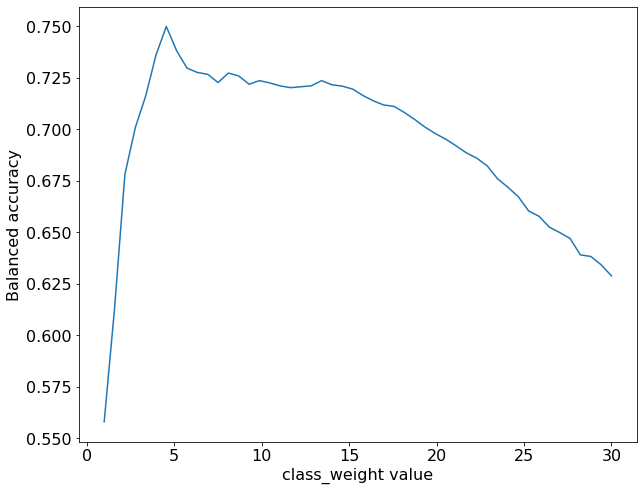

In [52]:
plt.figure(figsize=(10,8))
plt.plot(np.linspace(1,30,50), res)
plt.xlabel("class_weight value")
plt.ylabel("Balanced accuracy")
#plt.savefig('training.svg', format='svg')
plt.show()

In [53]:
print(best_weight)
print(best_score)

4.551020408163265
0.7499056546798483


In [33]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.7421857233819985

In [34]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [35]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.8113207547169812

Accuracy for the 0-class
0.6762820512820513

Balanced accuracy score: 
0.7438014029995162

Weighted accuracy
0.6958904109589041

Recall
0.8113207547169812

Precision
0.2986111111111111



In [36]:
print("We can see the most important factors for gender misclassification in out model are gender itself and age.")
lr_balanced.coef_

We can see the most important factors for gender misclassification in out model are gender itself and age.


array([[-0.36712903, -1.1280819 ,  0.19629272,  0.08342247, -0.09940886,
        -0.02221616, -0.20845625, -0.90102132, -0.16787255, -0.66592055,
        -0.34986003, -0.30727072, -0.00678589, -0.24249928]])

In [37]:
lr_balanced.intercept_

array([-0.72203374])

In [38]:
X

,Age,Gender,is_black,is_white,is_asian,is_latino,is_rest,is_happy,is_sad,is_calm,is_angry,is_fearful,is_surprised,is_disgusted
0,25,2,0,1,0,0,0,0,0,0,1,0,0,0
1,25,2,0,1,0,0,0,1,0,0,0,0,0,0
2,25,2,0,1,0,0,0,1,0,0,0,0,0,0
3,25,2,0,1,0,0,0,0,0,1,0,0,0,0
4,25,2,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,38,1,0,1,0,0,0,1,0,0,0,0,0,0
2425,27,2,0,0,1,0,0,1,0,0,0,0,0,0
2426,26,2,0,1,0,0,0,0,0,1,0,0,0,0
2427,26,1,0,0,1,0,0,0,0,1,0,0,0,0


In [39]:
T = X.copy()

In [40]:
list(zip(X.columns, lr_balanced.coef_[0]))

[('Age', -0.36712903455747725),
 ('Gender', -1.1280819036864782),
 ('is_black', 0.1962927235293701),
 ('is_white', 0.08342246931842885),
 ('is_asian', -0.09940886150341172),
 ('is_latino', -0.022216157641097564),
 ('is_rest', -0.20845624791030445),
 ('is_happy', -0.9010213222939686),
 ('is_sad', -0.16787255340332455),
 ('is_calm', -0.6659205548934336),
 ('is_angry', -0.3498600339753736),
 ('is_fearful', -0.30727071929663574),
 ('is_surprised', -0.0067858880295858905),
 ('is_disgusted', -0.24249928027940665)]

In [56]:
len(lr_balanced.coef_[0])

14

# Race Misclassification 

In [92]:
data_no_ai = data[data["Origin"] != "AI"]

In [93]:
race_misclass = race_misclassification(data_no_ai["Race"], data_no_ai["clarifai_race"]) == 1
sum(race_misclass)

319

In [94]:
len(data_no_ai)

2429

In [95]:
X = data_no_ai[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in race_misclass]

In [96]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [97]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [98]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [99]:
lr = LogisticRegression(solver='lbfgs') 

In [100]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.8677343143938503

In [101]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [102]:
sum(prediction)

2

In [103]:
is_actually_misclass = np.array(y_test) == 1
is_not_misclass = np.array(y_test) == 0

In [104]:
sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)

0.0

In [105]:
sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)

0.9936507936507937

In [106]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [107]:
lr = LogisticRegression(solver='lbfgs') 

In [108]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.5036056948313216

In [109]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,30,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

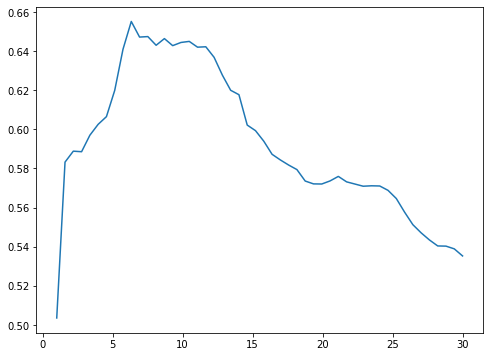

In [110]:
plt.figure(figsize=(8,6))
plt.plot(np.linspace(1,30,50), res)
plt.show()

In [111]:
print(best_weight)
print(best_score)

6.326530612244898
0.6551362683438156


In [89]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.6544041908846377

In [90]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [91]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.7777777777777778

Accuracy for the 0-class
0.50625

Balanced accuracy score: 
0.6420138888888889

Weighted accuracy
0.5397260273972603

Recall
0.7777777777777778

Precision
0.18134715025906736



In [68]:
print("We can see the most important factors for gender misclassification in out model are gender itself and age.")
lr_balanced.coef_

We can see the most important factors for gender misclassification in out model are gender itself and age.


array([[-0.08486118,  0.04248827,  0.06020328,  0.49429692, -0.22238696,
         0.62851311,  0.25926035,  0.24006305,  0.07921539,  0.29090969,
         0.2619214 ,  0.06377845,  0.00131217, -0.09134974]])

In [38]:
lr_balanced.intercept_

array([-0.72059514])

In [39]:
X

,Age,Gender,is_black,is_white,is_asian,is_latino,is_rest,is_happy,is_sad,is_calm,is_angry,is_fearful,is_surprised,is_disgusted
0,25,2,0,1,0,0,0,0,0,0,1,0,0,0
1,25,2,0,1,0,0,0,1,0,0,0,0,0,0
2,25,2,0,1,0,0,0,1,0,0,0,0,0,0
3,25,2,0,1,0,0,0,0,0,1,0,0,0,0
4,25,2,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,38,1,0,1,0,0,0,1,0,0,0,0,0,0
2425,27,2,0,0,1,0,0,1,0,0,0,0,0,0
2426,26,2,0,1,0,0,0,0,0,1,0,0,0,0
2427,26,1,0,0,1,0,0,0,0,1,0,0,0,0


In [40]:
T = X.copy()

In [112]:
list(zip(X.columns, lr_balanced.coef_[0]))

[('Age', -0.04944113800625767),
 ('Gender', 0.07653678417097275),
 ('is_black', 0.04676860433195728),
 ('is_white', 0.5415962350751914),
 ('is_asian', -0.2678822667982501),
 ('is_latino', 0.6574587652246395),
 ('is_rest', -0.1991949583917272),
 ('is_happy', -0.5277471177035697),
 ('is_sad', -0.22761129715622355),
 ('is_calm', -0.5320304026706317),
 ('is_angry', -0.2073868350281126),
 ('is_fearful', -0.3849184390191218),
 ('is_surprised', -0.23843845225882948),
 ('is_disgusted', -0.2581897825917533)]

# Age Misclassification Model  

In [122]:
data_no_ai = data[data["Origin"] != "AI"]

In [134]:
cl = age_misclassification(data["Age"], data["clarifai_age"]) == 1
ms = age_misclassification(data["Age"], data["microsoft_age"]) == 1
am = age_misclassification(data["Age"], data["amazon_age_average"]) == 1
fa = age_misclassification(data["Age"], data["face++_age"]) == 1

In [136]:
age_misclass = (cl | ms | am |fa)
sum(age_misclass)

1060

In [137]:
len(data)

2677

In [138]:
X = data[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in age_misclass]

In [139]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [140]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [141]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
lr = LogisticRegression(solver='lbfgs') 

In [143]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.6857142857142856

In [144]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [145]:
sum(prediction)

142

In [146]:
is_actually_misclass = np.array(y_test) == 1
is_not_misclass = np.array(y_test) == 0

In [147]:
sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)

0.5337423312883436

In [148]:
sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)

0.7698744769874477

In [149]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [150]:
lr = LogisticRegression(solver='lbfgs') 

In [151]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.6491178287612585

In [157]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,3,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

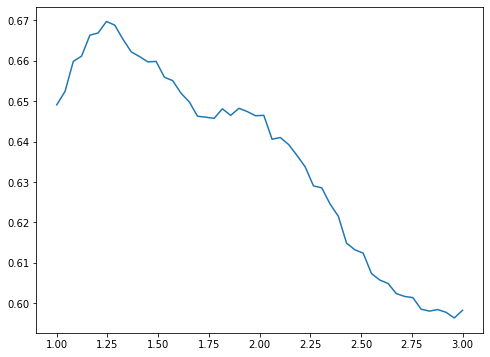

In [163]:
plt.figure(figsize=(8,6))
plt.plot(np.linspace(1,3,50), res)
plt.show()

In [164]:
print(best_weight)
print(best_score)

1.2448979591836735
0.6697571905599595


In [165]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.6697571905599595

In [166]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [167]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.6073619631901841

Accuracy for the 0-class
0.6945606694560669

Balanced accuracy score: 
0.6509613163231256

Weighted accuracy
0.6592039800995024

Recall
0.6073619631901841

Precision
0.5755813953488372



In [168]:
print("We can see the most important factors for gender misclassification in out model are gender itself and age.")
lr_balanced.coef_

We can see the most important factors for gender misclassification in out model are gender itself and age.


array([[-0.45161782, -0.23740359,  0.22130731,  0.33499432,  0.03904479,
         0.20104901, -0.17018871,  0.03500212,  0.08494222, -0.42541428,
         0.08670561,  0.03499769, -0.22256569,  0.22666161]])

In [169]:
lr_balanced.intercept_

array([-0.28606404])

In [170]:
X

,Age,Gender,is_black,is_white,is_asian,is_latino,is_rest,is_happy,is_sad,is_calm,is_angry,is_fearful,is_surprised,is_disgusted
0,25,2,0,1,0,0,0,0,0,0,1,0,0,0
1,25,2,0,1,0,0,0,1,0,0,0,0,0,0
2,25,2,0,1,0,0,0,1,0,0,0,0,0,0
3,25,2,0,1,0,0,0,0,0,1,0,0,0,0
4,25,2,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,25,1,0,1,0,0,0,0,0,0,0,0,0,0
2673,25,1,0,1,0,0,0,0,0,0,0,0,0,0
2674,35,1,0,1,0,0,0,0,0,0,0,0,0,0
2675,25,1,0,1,0,0,0,0,0,0,0,0,0,0


In [171]:
T = X.copy()

In [172]:
list(zip(X.columns, lr_balanced.coef_[0]))

[('Age', -0.4516178236576414),
 ('Gender', -0.23740359351347085),
 ('is_black', 0.22130731174907228),
 ('is_white', 0.33499432300546983),
 ('is_asian', 0.039044792406769994),
 ('is_latino', 0.2010490095282199),
 ('is_rest', -0.1701887103799458),
 ('is_happy', 0.03500212464087725),
 ('is_sad', 0.08494222273801627),
 ('is_calm', -0.4254142757587494),
 ('is_angry', 0.08670561039463187),
 ('is_fearful', 0.034997685904193256),
 ('is_surprised', -0.22256568660158516),
 ('is_disgusted', 0.22666161012061228)]

# Emotion Misclassification

In [11]:
data_no_ai = data[data["Origin"] != "AI"]

In [15]:
ms = emotion_misclassification(data_no_ai["Emotion"], data_no_ai["microsoft_emotion"]) == 1
am = emotion_misclassification(data_no_ai["Emotion"], data_no_ai["amazon_emotion"]) == 1
fa = emotion_misclassification(data_no_ai["Emotion"], data_no_ai["face++_emotion"]) == 1

In [18]:
emotion_misclass = (ms | am | fa)

In [19]:
X = data_no_ai[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in emotion_misclass]

In [20]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [21]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
lr = LogisticRegression(solver='lbfgs') 

In [24]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.7732762876419286

In [25]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [31]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [32]:
lr = LogisticRegression(solver='lbfgs') 

In [33]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.7289621110755091

In [34]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,30,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

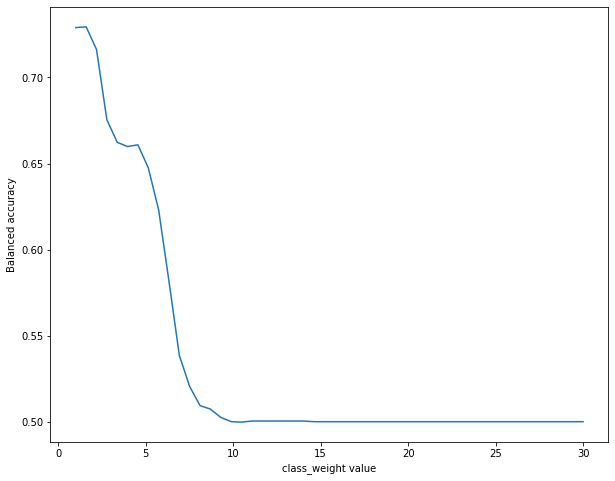

In [35]:
plt.figure(figsize=(10,8))
plt.plot(np.linspace(1,30,50), res)
plt.xlabel("class_weight value")
plt.ylabel("Balanced accuracy")
#plt.savefig('training.svg', format='svg')
plt.show()

In [36]:
print(best_weight)
print(best_score)

1.5918367346938775
0.729429326801919


In [37]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.729429326801919

In [38]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [39]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.5683453237410072

Accuracy for the 0-class
0.9026548672566371

Balanced accuracy score: 
0.7355000954988222

Weighted accuracy
0.7753424657534247

Recall
0.5683453237410072

Precision
0.7821782178217822

